In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv('insurance_claims.csv')

In [3]:
# Preview data
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [4]:
# --------------------- Data Preprocessing ---------------------

# Convert fraud_reported to binary numeric values without dropping rows
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})

In [5]:
# Drop columns not useful for modeling (identifiers)
drop_cols = ['policy_number', 'policy_bind_date', 'incident_date', 'incident_location',
             'insured_zip', 'auto_make', 'auto_model', 'auto_year', 'policy_state',
             'incident_state', 'incident_city', 'insured_hobbies', 'insured_occupation']

df = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [6]:
# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].astype(str)
    df[column] = le.fit_transform(df[column])

In [7]:
# Fill missing values with mode (for categorical) or mean (for numeric)
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

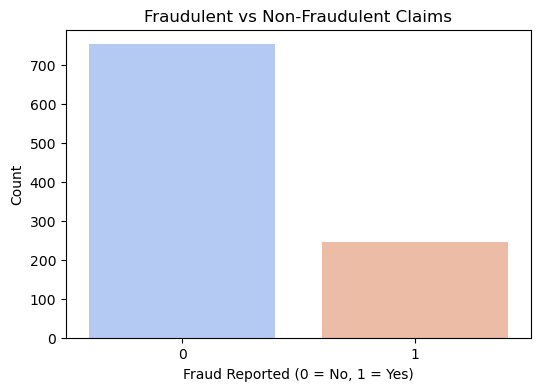

In [8]:
# --------------------- Exploratory Data Analysis (EDA) ---------------------

# Fraud count plot
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fraud_reported', palette='coolwarm')
plt.title('Fraudulent vs Non-Fraudulent Claims')
plt.xlabel('Fraud Reported (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

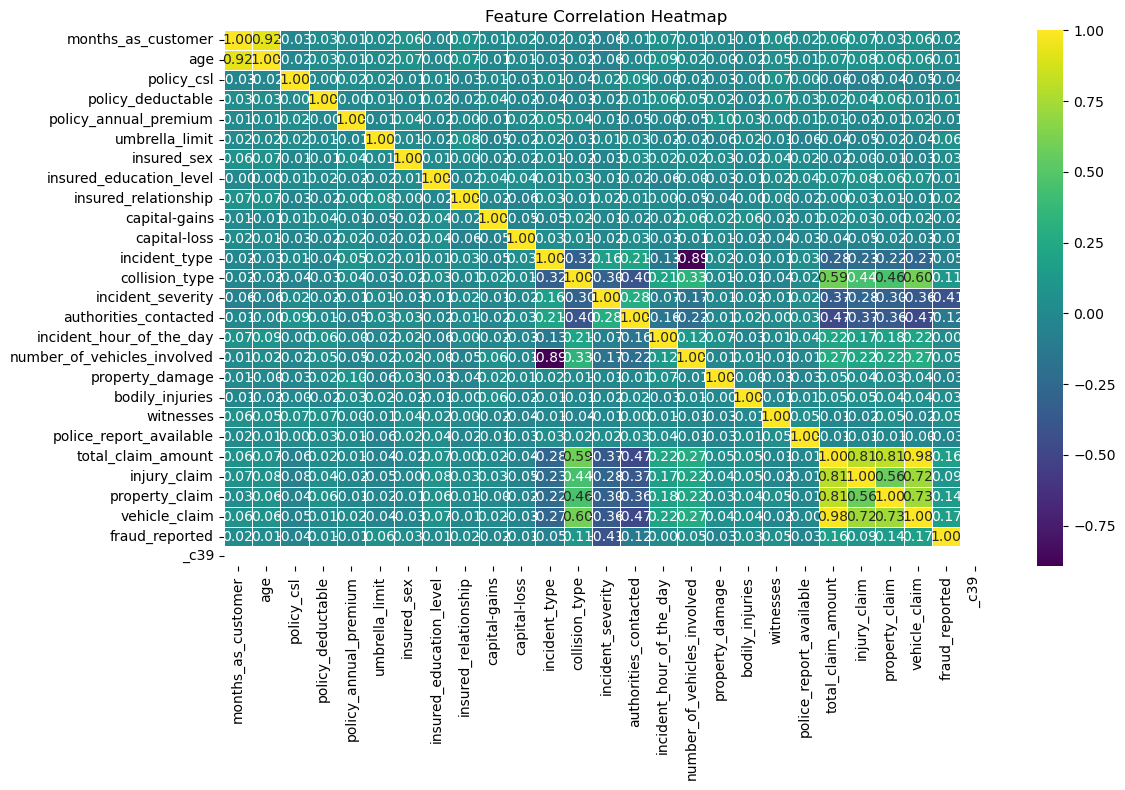

In [9]:
# Correlation heatmap with data labels
plt.figure(figsize=(12, 8))

# Compute correlation matrix
corr = df.corr(numeric_only=True)  # Ensure non-numeric columns don't cause issues

# Plot heatmap with annotations
sns.heatmap(corr, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5, linecolor='white')

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

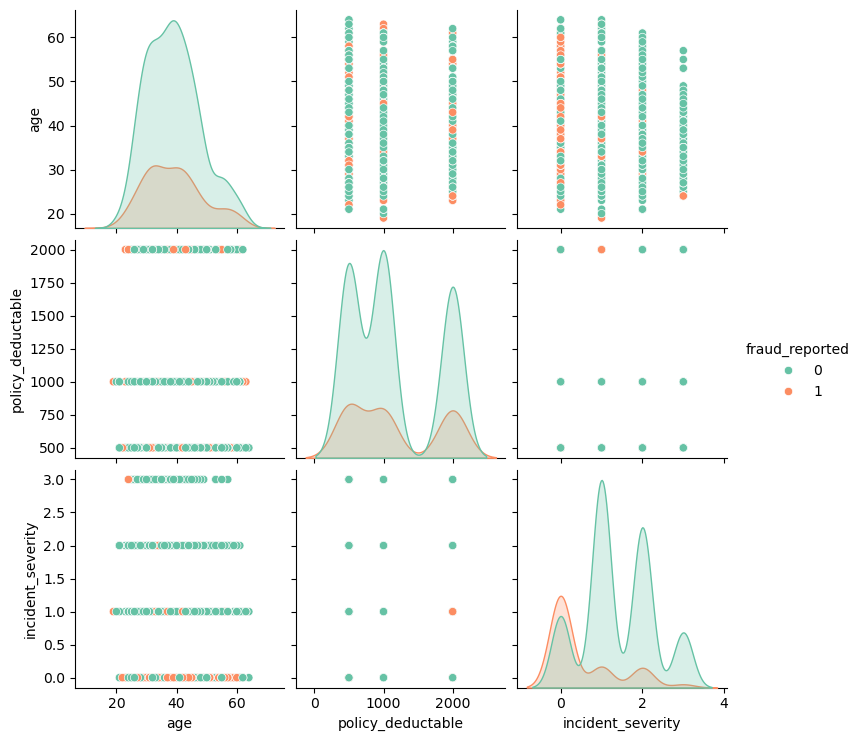

In [10]:
# Pairplot on a small subset
sns.pairplot(df[['age', 'policy_deductable', 'incident_severity', 'fraud_reported']].dropna(), hue='fraud_reported', palette='Set2')
plt.show()

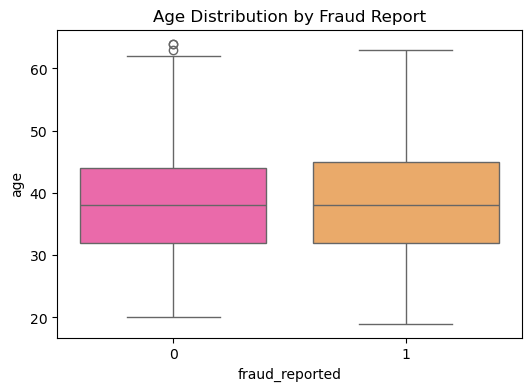

In [11]:
# Boxplot: age vs fraud
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='fraud_reported', y='age', palette='spring')
plt.title('Age Distribution by Fraud Report')
plt.show()

In [12]:
# --------------------- Feature Selection ---------------------
X = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']

In [13]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
# --------------------- Model Training ---------------------

# Logistic Regression

# Handle NaN values in X_train and X_test by imputing with mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

In [16]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [17]:
# Train SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

In [18]:
# --------------------- Model Evaluation ---------------------
models = {
    'Logistic Regression': (log_model, log_preds),
    'Random Forest': (rf_model, rf_preds),
    'SVM': (svm_model, svm_preds)
}

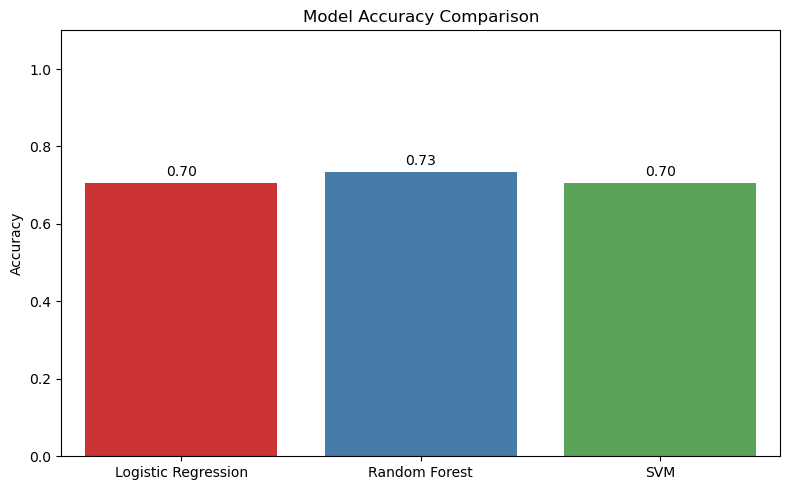

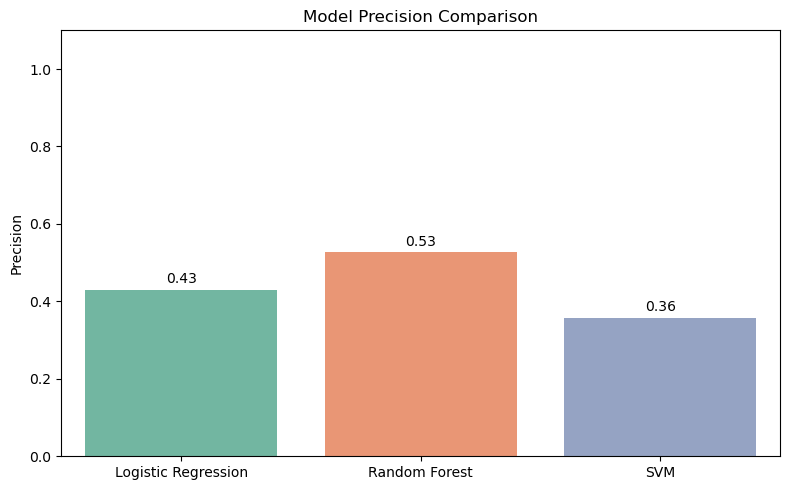

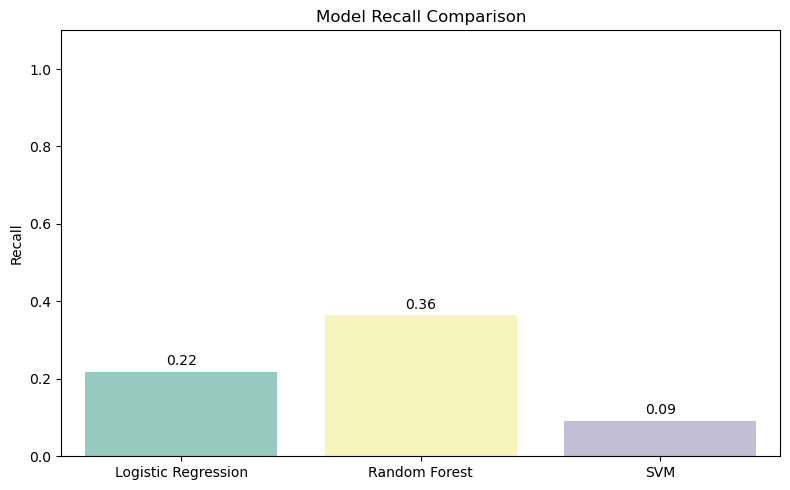

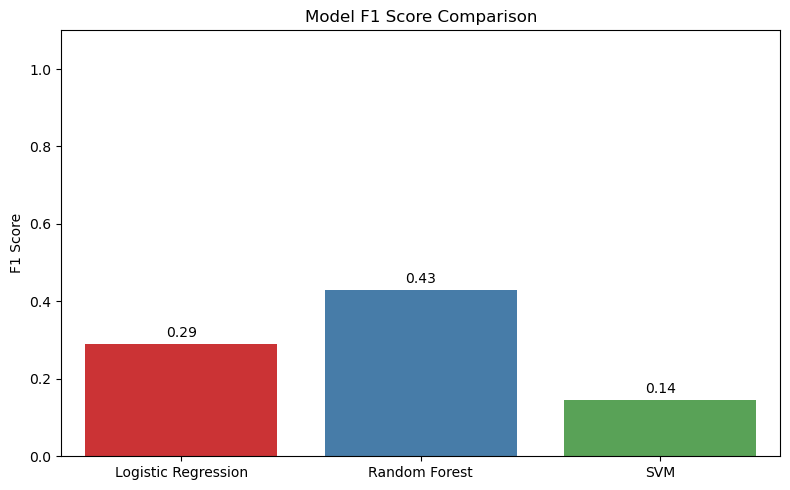

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize score dictionaries
accuracies = {}
precisions = {}
recalls = {}
f1_scores = {}

# Calculate scores for each model
for name, (_, preds) in models.items():
    accuracies[name] = accuracy_score(y_test, preds)
    precisions[name] = precision_score(y_test, preds)
    recalls[name] = recall_score(y_test, preds)
    f1_scores[name] = f1_score(y_test, preds)

# Helper function to plot bar chart with data labels
def plot_score_bar(score_dict, title, color_palette='Set2', ylabel='Score'):
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=list(score_dict.keys()), y=list(score_dict.values()), palette=color_palette)
    for i, value in enumerate(score_dict.values()):
        plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

# Plot all metric comparisons
plot_score_bar(accuracies, 'Model Accuracy Comparison', color_palette='Set1', ylabel='Accuracy')
plot_score_bar(precisions, 'Model Precision Comparison', color_palette='Set2', ylabel='Precision')
plot_score_bar(recalls, 'Model Recall Comparison', color_palette='Set3', ylabel='Recall')
plot_score_bar(f1_scores, 'Model F1 Score Comparison', color_palette='Set1', ylabel='F1 Score')


In [20]:
# Classification reports for all models
for name, (model, preds) in models.items():
    print(f"\n=== {name} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))


=== Logistic Regression ===
Confusion Matrix:
 [[129  16]
 [ 43  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       145
           1       0.43      0.22      0.29        55

    accuracy                           0.70       200
   macro avg       0.59      0.55      0.55       200
weighted avg       0.66      0.70      0.67       200


=== Random Forest ===
Confusion Matrix:
 [[127  18]
 [ 35  20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       145
           1       0.53      0.36      0.43        55

    accuracy                           0.73       200
   macro avg       0.66      0.62      0.63       200
weighted avg       0.71      0.73      0.72       200


=== SVM ===
Confusion Matrix:
 [[136   9]
 [ 50   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73     